# **Topic-Identification**

this notebook shows the nlp task ``topic identification`` in two examples. At first, a basic sample with just a few sentences as document which should demonstrate the basic functionality in topic identification.<br>
In a second example, a news article classification system with BERT will be shown.



# Basic example

source: [github](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/LDA.ipynb)



In [ ]:
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32917 sha256=de8f79e4cafb04fe025baa305651bd4f2ec3e6c20a1e2d8a5e2f1052a3ec334a
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [ ]:
# load resources
#
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

In [ ]:
# initalize 
#
tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [ ]:
# create sample documents
# doc_a = "Brocolli is good to eat. My brother likes to eat good brocolli, but not my mother."
# doc_b = "My mother spends a lot of time driving my brother around to baseball practice."
# doc_c = "Some health experts suggest that driving may cause increased tension and blood pressure."
# doc_d = "I often feel pressure to perform well at school, but my mother never seems to drive my brother to do better."
# doc_e = "Health professionals say that brocolli is good for your health." 

# compile sample documents into a list
# doc_set = [doc_a, doc_b, doc_c, doc_d, doc_e]

doc_set = [
           'Ben Roethlisburger, Mike Tomlin, and the rest of the Pittsburgh \
           Steelers are in unchartered terretory. For the first time in the \
           franchise\'s 87-year history, Pittsbourgh is undefeated through \
           nine games after the Steelers breezed by the Bengalas Sunday at \
           Heinz Field.'
           ]

In [ ]:
# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

In [ ]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=2, id2word = dictionary, passes=20)

In [ ]:
print(ldamodel.print_topics(num_topics=2, num_words=4))

[(0, '0.065*"steeler" + 0.039*"nine" + 0.039*"tomlin" + 0.039*"bengala"'), (1, '0.040*"steeler" + 0.040*"rest" + 0.040*"year" + 0.040*"ben"')]


In [ ]:
print(ldamodel.print_topics(num_topics=3, num_words=3))

[(0, '0.065*"steeler" + 0.039*"nine" + 0.039*"tomlin"'), (1, '0.040*"steeler" + 0.040*"rest" + 0.040*"year"')]


# News Article Classification

## preparations

**note:**<br>
 make sure that you use an GPU for that operation.
To train the model will take several time and with a GPU you can fasten that task. 

In [ ]:
# Note: after installing simpletransformers, one must restart the runtime

!pip install simpletransformers

To download a dataset from [kaggle.com](www.kaggle.com), one must sign up for an account first.<br><br>
Here, there are 2 ways shown, how to load the data set into colab:
- upload file from a local storage
- load dataset directly from kaggle.com

To download directly from kaggle there is an [official kaggle-api](https://github.com/Kaggle/kaggle-api) which makes the usage very easy.

Structure the colab environment for the data set from [kaggle.com](www.kaggle.com) as follows:

content/
>> kaggle/
>>> News_Category_Dataset_v2.json 


In [ ]:
# Create 'kaggle' folder
!mkdir '/content/kaggle'

#### Upload data set from a local storage

In [ ]:
#from google.colab import files

#files.upload()

#### Download data set from kaggle.com via api


* Create api-token:<br>
To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. 
Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and 
select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. 
Place this file in the location 'root/.kaggle/kaggle.json'.

* Secure your api-token:<br>
For your security, ensure that other users of your computer do not have read access to your credentials.
On Unix-based systems you can do this with the following command:
chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Prepare folders in colab environment
import os

os.mkdir('/root/.kaggle')
os.chdir('/root/.kaggle')

In [ ]:
# After downloading the api-token, bring it into colab:

from google.colab import files

files.upload()

In [ ]:
# Change access of the api-token
os.chmod('/root/.kaggle/kaggle.json', 600)

# Get back to the kaggle folder
os.chdir('/content/kaggle')

In [ ]:
# Download dataset
!kaggle datasets download -d rmisra/news-category-dataset

 35% 9.00M/25.4M [00:00<00:01, 10.6MB/s]
100% 25.4M/25.4M [00:00<00:00, 29.1MB/s]


In [ ]:
 # Unpack dataset
 
 !unzip news-category-dataset.zip

Archive:  news-category-dataset.zip
  inflating: News_Category_Dataset_v2.json  


In [ ]:
# Get back to default ('content/') location
!cd ..

## Load data set

We import all necessary libraries. Among the simpletransformers library,
we also need functions from scikit-learn (Pedregosa et al., 2011) and the Pandas
library (Reback et al., 2020) to load and extract our training text corpus from the
JSON file.
In google-colab, pandas and scikit-learn are pre-installed.
We extract our training text corpus and import it into a Pandas data frame df (line
7).

In [ ]:
import pandas as pd
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Read data from JSON
df = pd.read_json("/content/kaggle/News_Category_Dataset_v2.json", orient="records", lines=True)

Look at some of the dataset entries:

In [ ]:
df.head(3)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26


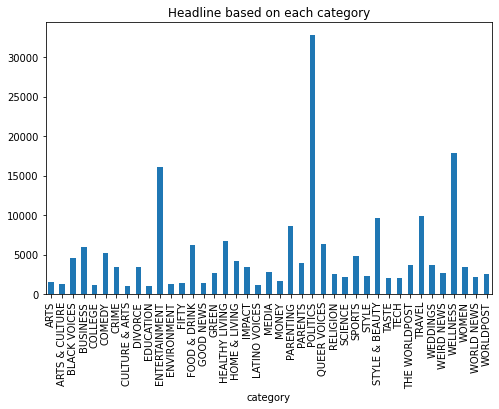

In [ ]:
# Display category distribution
from matplotlib import pyplot as plt

ax = df.groupby("category").count()["headline"].plot(kind="bar", 
                                                 figsize=(8, 5),
                                                 title="Headline based on each category")
plt.show()

## Data Preparation

Because our classification model expects its input in a certain structure, we prepare
a new data frame data. This data frame has a column text that contains the
concatenated headlines and corresponding short descriptions. We create a
column labels that contains the category of the article.

In [ ]:
data = pd.DataFrame()
data["text"] = df.headline + " " + df.short_description
data["labels"] = df.category

# show the new structure
data.head(3)

,text,labels
0,There Were 2 Mass Shootings In Texas Last Week...,CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT


The classification model needs to get only unique labels. ``lables`` lists only the unique labels from ``data``.

In [ ]:
labels = list(data["labels"].unique())

Since our model accepts only numeric values for the target features (our article categories),
we need to use scikit-learn’s LabelEncoder to encode our string-based
labels (“CRIME,” “SPORTS,” “ENTERTAINMENT”) as integers

In [ ]:
# Convert labels to numerical values
le = preprocessing.LabelEncoder()
le.fit(labels)
data["labels"] = le.transform(data["labels"])

We split our data set into training (80%) and evaluation set (20%) using scikit-learn’s
train_test_split function. Please note that we refrain from creating a
third set for the final evaluation to simplify this demonstration.

In [ ]:
train_df, eval_df = train_test_split(data, test_size=0.2)

## Create classification model

We create our classification model. We use a model
bert_base_uncased (uncased monolingual English version of BERT published by
Google) from the “bert” model family. The number of labels (categories) is set
through the num_labels parameter.

In [ ]:
# Create a classification model
model = ClassificationModel('bert', 'bert-base-uncased', 
                            num_labels=len(labels))

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

## Train model

We can start training our model. This automatically downloads the pre-trained
BERT model, initializes its parameters, and preprocesses our training data using a
subword tokenizer before the actual training process is started.

In [ ]:
# Train the model
model.train_model(train_df)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/20086 [00:00<?, ?it/s]

(20086, 1.9867055759925916)

## Evaluation

We evaluate the model on our evaluation set.

In [ ]:
# Evaluate the model
result, model_outputs, predictions = model.eval_model(eval_df)

Running Evaluation:   0%|          | 0/5022 [00:00<?, ?it/s]

In [ ]:
print(result)

{'mcc': 0.49016621125018, 'eval_loss': 1.715693072564618}


In [ ]:
print(model_outputs)

[[-2.40039062  0.64746094  2.1640625  ...  1.6640625  -0.43310547
  -2.07421875]
 [ 0.06463623 -1.57128906  0.15710449 ... -0.60644531  2.0078125
   5.44140625]
 [-0.49487305 -2.19726562 -0.80712891 ...  0.68652344 -3.109375
  -1.00585938]
 ...
 [-1.13378906 -2.58203125 -1.03710938 ... -0.61523438 -1.76953125
  -1.53710938]
 [-2.7265625   0.74169922  1.65234375 ...  1.18359375  1.11816406
  -1.46777344]
 [-0.97265625 -1.86132812 -1.03613281 ... -0.58691406 -2.1484375
  -1.52441406]]
